In [6]:
import os
import glob
from PIL import Image,ImageDraw,ImageFont,ImageFilter
import numpy as np
import random,math,copy
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib import text as mtext
from matplotlib import font_manager
import cv2
import re

#map4_path = '/home/zekun/Documents/Dornsife/SynthMaps/concat_out/'
#save_path = '/home/zekun/Documents/Dornsife/SynthMaps/concat_out_text/'
#fonts_path = '/home/zekun/Documents/Dornsife/SynthMaps/fonts/'

map4_path = '/data/map_share_data/concat_out/'
save_path = '/data/zekunl/synthMap_application/generate_data/concat_out_text_space/'
fonts_path = '/data/zekunl/synthMap_application/generate_data/fonts/'

# load the words
word_set = set()
geoname_f = open("/data/zekunl/synthMap_application/generate_data//GB.txt", "r")
for line in geoname_f:
    cols = re.split(r'\t+', line.rstrip('\t'))
    words = cols[1].split(' ')
    for w in words:
        word_set.add(w.strip('()'))
geoname_f.close()
set_len = len(word_set)
print len(word_set), ' words in total'
print 'eg:', list(word_set)[0:10]

30082  words in total
eg: ['', 'Glendhu', 'Asterleigh', 'Belnahua', 'Legrow', 'Bircotes', 'Caer', 'Wolfhamcote', 'Mackinnon', "Fisherman's"]


In [2]:
# Notes for inserting text on images: 
# if no rotation or customized font is required, then cv2.putText and cv2.getTextsize would work perfectly
# But one reason NOT to use  cv2 to insert text is its incapability to insert customized font styles
# even loadFontData did not work for me in python


def fig2data ( fig ):
    # from http://www.icare.univ-lille1.fr/tutorials/convert_a_matplotlib_figure
    """
    @brief Convert a Matplotlib figure to a 3D numpy array with RGB channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGB values
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.frombuffer ( fig.canvas.tostring_rgb(), dtype=np.uint8 )
    buf.shape = ( w, h,3 )
 
    # canvas.tostring_argb give pixmap in RGB mode. Roll the ALPHA channel to have it in RGB mode
    #buf = np.roll ( buf, 3, axis = 2 )
    return buf

def fig2img ( fig ):
    # from http://www.icare.univ-lille1.fr/tutorials/convert_a_matplotlib_figure
    """
    @brief Convert a Matplotlib figure to a PIL Image in RGB format and return it
    @param fig a matplotlib figure
    @return a Python Imaging Library ( PIL ) image
    """
    # put the figure pixmap into a numpy array
    buf = fig2data ( fig )
    w, h, d = buf.shape
    return Image.frombuffer( "RGB", ( w ,h ), buf.tostring( ) ).transpose(Image.FLIP_TOP_BOTTOM)

def visualize_points(text_layer, pts):
    '''
    text_layer is of PIL image type
    pts is an array
    '''
    text_layer = np.array(text_layer).astype(np.uint8).copy()
    
    for pt in pts:
        pt = [int(a) for a in pt]
        cv2.circle(text_layer,(pt[0],pt[1]), 5, (255,0,0),10)
    plt.imshow(text_layer)
    plt.show()
    

In [3]:
# generate text layer
def text_on_canvas(text, myf, ro, color = (0.5,0.5,0.5), margin = 1):
    axis_lim = 1
    
    fig = plt.figure(figsize = (5,5), dpi=100)
    plt.axis([0, axis_lim, 0, axis_lim])
    
    # place the top left corner at (axis_lim/20,axis_lim/2) to avoid clip during rotation
    aa = plt.text(axis_lim/20.,axis_lim/2., text, color = color, ha='left', va = 'top', fontproperties = myf, rotation = ro, wrap=False)
    plt.axis('off')
    text_layer = fig2img(fig) # convert to image
    plt.close()
    
    we = aa.get_window_extent()
    min_x, min_y, max_x, max_y = we.xmin, 500 - we.ymax, we.xmax, 500 - we.ymin
    box = (min_x-margin, min_y-margin, max_x+margin, max_y+margin)
    
    # return coordinates to further calculate the bbox of rotated text
    return text_layer, min_x, min_y, max_x, max_y 



def geneText(text, font_family, font_size, font_color, rot_angle, style):
    # if font size too big, then put.text automatically adjust the position, which makes computed position errorous.
    myf = font_manager.FontProperties(fname=font_family, size=font_size)

    if style < 8: # rotated text
        fcolor = tuple(a/255. for a in font_color) # convert from [0,255] to [0,1]
        # no rotation, just to get the minimum bbox
        htext_layer, min_x, min_y, max_x, max_y = text_on_canvas(text, myf, ro = 0, color = fcolor)
    
        #print min_x,min_y,max_x,  max_y
        M = cv2.getRotationMatrix2D((min_x,min_y),rot_angle,1)
        # pts is 4x3 matrix
        pts = np.array([[min_x, min_y, 1],[max_x, min_y, 1],[max_x, max_y, 1],[min_x, max_y,1]]) # clockwise
        affine_pts = np.dot(M, pts.T).T

        if (affine_pts<= 0).any()  or (affine_pts>= 500).any() :
            return 0, 0 # exceed boundary. skip
        else:
            text_layer = htext_layer.rotate(rot_angle,center=(min_x, min_y),fillcolor='white')

            #visualize_points(htext_layer, pts)
            #visualize_points(text_layer, affine_pts)
            return text_layer, affine_pts
    
    else:
        raise NotImplementedError

    
    

In [4]:
# add to map
def zk_addToMap(img_bg,text_layer, p):
    text_bi = np.array(text_layer)[:,:,0].copy()
    text_bina = text_bi.copy()
    
    # binarizatoin. if text region, set to 1, if not text region, set to 0. 
    # since no text region has color intensity greater than 128. thus we use 255 as the threshold
    #text_bi[text_bina != 255] = 255
    #text_bi[text_bina == 255] = 0  
    text_bi[text_bina <= 130] = 255
    text_bi[text_bina > 130] = 0  
    text_bi = Image.fromarray(text_bi)
    text_bi.filter(ImageFilter.GaussianBlur(4))
    
    img_bg.paste(text_layer,(p[0],p[1]),mask=text_bi)
    return img_bg,text_bina


In [7]:
# process
word_set = list(word_set)

fonts = glob.glob(fonts_path + '/*.ttf')
map4_set = glob.glob(map4_path + '/*.jpg')

words_size = len(word_set)
cnt = 0 # process on #cnt images
text_num_thresh = 5


for patch_path in map4_set[734:]:
    print 'processing', patch_path
    img_bg_pil = Image.open(patch_path).convert('RGBA')
    W, H = img_bg_pil.size
    img_bg_cv = cv2.imread(patch_path)
    info_f = open(save_path +os.path.basename(patch_path)[:-4]+'.txt', 'w')
    

    #for i in range(text_num):
    text_num = 0
    while(text_num < text_num_thresh):
        # get input text string
        text = word_set[random.randint(1, words_size-1)].strip()
        text = re.sub('[^0-9A-Za-z]+', '', text) # remove symbols
        while(len(text) < 1): # text length is zero. no character except for spaces
            text = word_set[random.randint(1, words_size-1)].strip()
            text = re.sub('[^0-9A-Za-z]+', '', text) # remove symbols
            
        # font specification
        font_face = fonts[random.randint(0, len(fonts)-1)]
        font_size = random.randint(10, 80)
        ro = random.randint(-90, 90)
        fcolor = random.randint(0, 128)* np.ones((3))
        
        # some variations to the original input text
        if np.random.randint(0,2): # 50% chance to capitalize the text
            text = text.upper()
           
        
        # 50% chance to insert blank space
        if np.random.randint(0,2): 
            insert_type = np.random.randint(0,3)
            if insert_type == 0: # 1/3 of the chance to insert ONE blank space between chars
                text = " ".join(text)
            if insert_type == 1: #1/3 of the chance to insert TWO blank space bween chars
                text = "  ".join(text)
            if insert_type == 2: #1/3 of the chance to insert FIVE blank space bween chars
                text = "     ".join(text)
                
        #print text
        text_layer, af_pts = geneText(text, font_face, font_size, font_color = fcolor, rot_angle = ro, style = 1)


        if text_layer != 0:
            text_w, text_h = text_layer.size
            upper_left_pos = (random.randint(0, W - text_w/2), random.randint(0, H - text_h / 2)) # upper-left pos on bg img

            # these are the text region positions on original text layer
            left = int(np.min(af_pts[:,0]))
            up = int(np.min(af_pts[:,1]))
            right = int(np.max(af_pts[:,0]))
            bottom = int(np.max(af_pts[:,1]))

            text_layer = text_layer.crop(( left, up, right, bottom )) # crop out the text region
            img_bg_pil,_ = zk_addToMap(img_bg_pil, text_layer, upper_left_pos ) # place on the bg image


            # calculate the tight bbox position on the bg image ( infer from original text layer)
            x1, y1 = af_pts[0]
            x2, y2 = af_pts[1]
            x3, y3 = af_pts[2]
            x4, y4 = af_pts[3]
            x1, x2 = x1 - left + upper_left_pos[0], x2 - left + upper_left_pos[0]
            x3, x4 = x3 - left + upper_left_pos[0], x4 - left  + upper_left_pos[0]
            y1, y2 = y1 - up + upper_left_pos[1], y2 - up + upper_left_pos[1]
            y3, y4 = y3 - up + upper_left_pos[1], y4 - up + upper_left_pos[1]

            c_x, c_y = 0.5 * (x1 + x3), 0.5 * (y1 + y3)

            info_f.write('%d,%d,%d,%d,%d,%d,%d,%d,%d,%d\n' % ( x1, y1, x2, y2, x3, y3, x4, y4, c_x, c_y))

            text_num += 1


        img_bg_pil.convert('RGB').save(save_path +os.path.basename(patch_path))
        
        
    info_f.close()
        
    #cnt += 1
    #if cnt == 2:
    #    break
    
print 'done processing'     

processing /data/map_share_data/concat_out/concat3_32333_21486.jpg


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: the frombuffer defaults will change in Pillow 7.0.0; for portability, change the call to read:
  frombuffer(mode, size, data, 'raw', mode, 0, 1)


processing /data/map_share_data/concat_out/concat3_32333_21487.jpg
processing /data/map_share_data/concat_out/concat3_32333_21488.jpg
processing /data/map_share_data/concat_out/concat3_32333_21489.jpg
processing /data/map_share_data/concat_out/concat3_32333_21490.jpg
processing /data/map_share_data/concat_out/concat3_32333_21491.jpg
processing /data/map_share_data/concat_out/concat3_32333_21492.jpg
processing /data/map_share_data/concat_out/concat3_32333_21493.jpg
processing /data/map_share_data/concat_out/concat3_32333_21494.jpg
processing /data/map_share_data/concat_out/concat3_32333_21495.jpg
processing /data/map_share_data/concat_out/concat3_32333_21496.jpg
processing /data/map_share_data/concat_out/concat3_32333_21497.jpg
processing /data/map_share_data/concat_out/concat3_32333_21498.jpg
processing /data/map_share_data/concat_out/concat3_32333_21499.jpg
processing /data/map_share_data/concat_out/concat3_32333_21500.jpg
processing /data/map_share_data/concat_out/concat3_32333_21501

processing /data/map_share_data/concat_out/concat3_32333_21610.jpg
processing /data/map_share_data/concat_out/concat3_32333_21611.jpg
processing /data/map_share_data/concat_out/concat3_32333_21612.jpg
processing /data/map_share_data/concat_out/concat3_32333_21613.jpg
processing /data/map_share_data/concat_out/concat3_32333_21614.jpg
processing /data/map_share_data/concat_out/concat3_32333_21615.jpg
processing /data/map_share_data/concat_out/concat3_32333_21616.jpg
processing /data/map_share_data/concat_out/concat3_32333_21617.jpg
processing /data/map_share_data/concat_out/concat3_32333_21618.jpg
processing /data/map_share_data/concat_out/concat3_32333_21619.jpg
processing /data/map_share_data/concat_out/concat3_32333_21620.jpg
processing /data/map_share_data/concat_out/concat3_32333_21621.jpg
processing /data/map_share_data/concat_out/concat3_32333_21622.jpg
processing /data/map_share_data/concat_out/concat3_32333_21623.jpg
processing /data/map_share_data/concat_out/concat3_32333_21624

processing /data/map_share_data/concat_out/concat3_32334_21435.jpg
processing /data/map_share_data/concat_out/concat3_32334_21436.jpg
processing /data/map_share_data/concat_out/concat3_32334_21437.jpg
processing /data/map_share_data/concat_out/concat3_32334_21438.jpg
processing /data/map_share_data/concat_out/concat3_32334_21439.jpg
processing /data/map_share_data/concat_out/concat3_32334_21440.jpg
processing /data/map_share_data/concat_out/concat3_32334_21441.jpg
processing /data/map_share_data/concat_out/concat3_32334_21442.jpg
processing /data/map_share_data/concat_out/concat3_32334_21443.jpg
processing /data/map_share_data/concat_out/concat3_32334_21444.jpg
processing /data/map_share_data/concat_out/concat3_32334_21445.jpg
processing /data/map_share_data/concat_out/concat3_32334_21446.jpg
processing /data/map_share_data/concat_out/concat3_32334_21447.jpg
processing /data/map_share_data/concat_out/concat3_32334_21448.jpg
processing /data/map_share_data/concat_out/concat3_32334_21449

processing /data/map_share_data/concat_out/concat3_32334_21558.jpg
processing /data/map_share_data/concat_out/concat3_32334_21559.jpg
processing /data/map_share_data/concat_out/concat3_32334_21560.jpg
processing /data/map_share_data/concat_out/concat3_32334_21561.jpg
processing /data/map_share_data/concat_out/concat3_32334_21562.jpg
processing /data/map_share_data/concat_out/concat3_32334_21563.jpg
processing /data/map_share_data/concat_out/concat3_32334_21564.jpg
processing /data/map_share_data/concat_out/concat3_32334_21565.jpg
processing /data/map_share_data/concat_out/concat3_32334_21566.jpg
processing /data/map_share_data/concat_out/concat3_32334_21567.jpg
processing /data/map_share_data/concat_out/concat3_32334_21568.jpg
processing /data/map_share_data/concat_out/concat3_32334_21569.jpg
processing /data/map_share_data/concat_out/concat3_32334_21570.jpg
processing /data/map_share_data/concat_out/concat3_32334_21571.jpg
processing /data/map_share_data/concat_out/concat3_32334_21572

processing /data/map_share_data/concat_out/concat3_32335_21383.jpg
processing /data/map_share_data/concat_out/concat3_32335_21384.jpg
processing /data/map_share_data/concat_out/concat3_32335_21385.jpg
processing /data/map_share_data/concat_out/concat3_32335_21386.jpg
processing /data/map_share_data/concat_out/concat3_32335_21387.jpg
processing /data/map_share_data/concat_out/concat3_32335_21388.jpg
processing /data/map_share_data/concat_out/concat3_32335_21389.jpg
processing /data/map_share_data/concat_out/concat3_32335_21390.jpg
processing /data/map_share_data/concat_out/concat3_32335_21391.jpg
processing /data/map_share_data/concat_out/concat3_32335_21392.jpg
processing /data/map_share_data/concat_out/concat3_32335_21393.jpg
processing /data/map_share_data/concat_out/concat3_32335_21394.jpg
processing /data/map_share_data/concat_out/concat3_32335_21395.jpg
processing /data/map_share_data/concat_out/concat3_32335_21396.jpg
processing /data/map_share_data/concat_out/concat3_32335_21397

processing /data/map_share_data/concat_out/concat3_32335_21506.jpg
processing /data/map_share_data/concat_out/concat3_32335_21507.jpg
processing /data/map_share_data/concat_out/concat3_32335_21508.jpg
processing /data/map_share_data/concat_out/concat3_32335_21509.jpg
processing /data/map_share_data/concat_out/concat3_32335_21510.jpg
processing /data/map_share_data/concat_out/concat3_32335_21511.jpg
processing /data/map_share_data/concat_out/concat3_32335_21512.jpg
processing /data/map_share_data/concat_out/concat3_32335_21513.jpg
processing /data/map_share_data/concat_out/concat3_32335_21514.jpg
processing /data/map_share_data/concat_out/concat3_32335_21515.jpg
processing /data/map_share_data/concat_out/concat3_32335_21516.jpg
processing /data/map_share_data/concat_out/concat3_32335_21517.jpg
processing /data/map_share_data/concat_out/concat3_32335_21518.jpg
processing /data/map_share_data/concat_out/concat3_32335_21519.jpg
processing /data/map_share_data/concat_out/concat3_32335_21520

processing /data/map_share_data/concat_out/concat3_32335_21629.jpg
processing /data/map_share_data/concat_out/concat3_32335_21630.jpg
processing /data/map_share_data/concat_out/concat3_32335_21631.jpg
processing /data/map_share_data/concat_out/concat3_32335_21632.jpg
processing /data/map_share_data/concat_out/concat3_32335_21633.jpg
processing /data/map_share_data/concat_out/concat3_32335_21634.jpg
processing /data/map_share_data/concat_out/concat3_32335_21635.jpg
processing /data/map_share_data/concat_out/concat3_32335_21636.jpg
processing /data/map_share_data/concat_out/concat3_32335_21637.jpg
processing /data/map_share_data/concat_out/concat3_32335_21638.jpg
processing /data/map_share_data/concat_out/concat3_32335_21639.jpg
processing /data/map_share_data/concat_out/concat3_32335_21640.jpg
processing /data/map_share_data/concat_out/concat3_32335_21641.jpg
processing /data/map_share_data/concat_out/concat3_32335_21642.jpg
processing /data/map_share_data/concat_out/concat3_32335_21643

processing /data/map_share_data/concat_out/concat3_32336_21454.jpg
processing /data/map_share_data/concat_out/concat3_32336_21455.jpg
processing /data/map_share_data/concat_out/concat3_32336_21456.jpg
processing /data/map_share_data/concat_out/concat3_32336_21457.jpg
processing /data/map_share_data/concat_out/concat3_32336_21458.jpg
processing /data/map_share_data/concat_out/concat3_32336_21459.jpg
processing /data/map_share_data/concat_out/concat3_32336_21460.jpg
processing /data/map_share_data/concat_out/concat3_32336_21461.jpg
processing /data/map_share_data/concat_out/concat3_32336_21462.jpg
processing /data/map_share_data/concat_out/concat3_32336_21463.jpg
processing /data/map_share_data/concat_out/concat3_32336_21464.jpg
processing /data/map_share_data/concat_out/concat3_32336_21465.jpg
processing /data/map_share_data/concat_out/concat3_32336_21466.jpg
processing /data/map_share_data/concat_out/concat3_32336_21467.jpg
processing /data/map_share_data/concat_out/concat3_32336_21468

processing /data/map_share_data/concat_out/concat3_32336_21577.jpg
processing /data/map_share_data/concat_out/concat3_32336_21578.jpg
processing /data/map_share_data/concat_out/concat3_32336_21579.jpg
processing /data/map_share_data/concat_out/concat3_32336_21580.jpg
processing /data/map_share_data/concat_out/concat3_32336_21581.jpg
processing /data/map_share_data/concat_out/concat3_32336_21582.jpg
processing /data/map_share_data/concat_out/concat3_32336_21583.jpg
processing /data/map_share_data/concat_out/concat3_32336_21584.jpg
processing /data/map_share_data/concat_out/concat3_32336_21585.jpg
processing /data/map_share_data/concat_out/concat3_32336_21586.jpg
processing /data/map_share_data/concat_out/concat3_32336_21587.jpg
processing /data/map_share_data/concat_out/concat3_32336_21588.jpg
processing /data/map_share_data/concat_out/concat3_32336_21589.jpg
processing /data/map_share_data/concat_out/concat3_32336_21590.jpg
processing /data/map_share_data/concat_out/concat3_32336_21591

processing /data/map_share_data/concat_out/concat3_32337_21402.jpg
processing /data/map_share_data/concat_out/concat3_32337_21403.jpg
processing /data/map_share_data/concat_out/concat3_32337_21404.jpg
processing /data/map_share_data/concat_out/concat3_32337_21405.jpg
processing /data/map_share_data/concat_out/concat3_32337_21406.jpg
processing /data/map_share_data/concat_out/concat3_32337_21407.jpg
processing /data/map_share_data/concat_out/concat3_32337_21408.jpg
processing /data/map_share_data/concat_out/concat3_32337_21409.jpg
processing /data/map_share_data/concat_out/concat3_32337_21410.jpg
processing /data/map_share_data/concat_out/concat3_32337_21411.jpg
processing /data/map_share_data/concat_out/concat3_32337_21412.jpg
processing /data/map_share_data/concat_out/concat3_32337_21413.jpg
processing /data/map_share_data/concat_out/concat3_32337_21414.jpg
processing /data/map_share_data/concat_out/concat3_32337_21415.jpg
processing /data/map_share_data/concat_out/concat3_32337_21416

processing /data/map_share_data/concat_out/concat3_32337_21525.jpg
processing /data/map_share_data/concat_out/concat3_32337_21526.jpg
processing /data/map_share_data/concat_out/concat3_32337_21527.jpg
processing /data/map_share_data/concat_out/concat3_32337_21528.jpg
processing /data/map_share_data/concat_out/concat3_32337_21529.jpg
processing /data/map_share_data/concat_out/concat3_32337_21530.jpg
processing /data/map_share_data/concat_out/concat3_32337_21531.jpg
processing /data/map_share_data/concat_out/concat3_32337_21532.jpg
processing /data/map_share_data/concat_out/concat3_32337_21533.jpg
processing /data/map_share_data/concat_out/concat3_32337_21534.jpg
processing /data/map_share_data/concat_out/concat3_32337_21535.jpg
processing /data/map_share_data/concat_out/concat3_32337_21536.jpg
processing /data/map_share_data/concat_out/concat3_32337_21537.jpg
processing /data/map_share_data/concat_out/concat3_32337_21538.jpg
processing /data/map_share_data/concat_out/concat3_32337_21539

processing /data/map_share_data/concat_out/concat3_32338_21350.jpg
processing /data/map_share_data/concat_out/concat3_32338_21351.jpg
processing /data/map_share_data/concat_out/concat3_32338_21352.jpg
processing /data/map_share_data/concat_out/concat3_32338_21353.jpg
processing /data/map_share_data/concat_out/concat3_32338_21354.jpg
processing /data/map_share_data/concat_out/concat3_32338_21355.jpg
processing /data/map_share_data/concat_out/concat3_32338_21356.jpg
processing /data/map_share_data/concat_out/concat3_32338_21357.jpg
processing /data/map_share_data/concat_out/concat3_32338_21358.jpg
processing /data/map_share_data/concat_out/concat3_32338_21359.jpg
processing /data/map_share_data/concat_out/concat3_32338_21360.jpg
processing /data/map_share_data/concat_out/concat3_32338_21361.jpg
processing /data/map_share_data/concat_out/concat3_32338_21362.jpg
processing /data/map_share_data/concat_out/concat3_32338_21363.jpg
processing /data/map_share_data/concat_out/concat3_32338_21364

processing /data/map_share_data/concat_out/concat3_32338_21473.jpg
processing /data/map_share_data/concat_out/concat3_32338_21474.jpg
processing /data/map_share_data/concat_out/concat3_32338_21475.jpg
processing /data/map_share_data/concat_out/concat3_32338_21476.jpg
processing /data/map_share_data/concat_out/concat3_32338_21477.jpg
processing /data/map_share_data/concat_out/concat3_32338_21478.jpg
processing /data/map_share_data/concat_out/concat3_32338_21479.jpg
processing /data/map_share_data/concat_out/concat3_32338_21480.jpg
processing /data/map_share_data/concat_out/concat3_32338_21481.jpg
processing /data/map_share_data/concat_out/concat3_32338_21482.jpg
processing /data/map_share_data/concat_out/concat3_32338_21483.jpg
processing /data/map_share_data/concat_out/concat3_32338_21484.jpg
processing /data/map_share_data/concat_out/concat3_32338_21485.jpg
processing /data/map_share_data/concat_out/concat3_32338_21486.jpg
processing /data/map_share_data/concat_out/concat3_32338_21487

processing /data/map_share_data/concat_out/concat3_32338_21596.jpg
processing /data/map_share_data/concat_out/concat3_32338_21597.jpg
processing /data/map_share_data/concat_out/concat3_32338_21598.jpg
processing /data/map_share_data/concat_out/concat3_32338_21599.jpg
processing /data/map_share_data/concat_out/concat3_32338_21600.jpg
processing /data/map_share_data/concat_out/concat3_32338_21601.jpg
processing /data/map_share_data/concat_out/concat3_32338_21602.jpg
processing /data/map_share_data/concat_out/concat3_32338_21603.jpg
processing /data/map_share_data/concat_out/concat3_32338_21604.jpg
processing /data/map_share_data/concat_out/concat3_32338_21605.jpg
processing /data/map_share_data/concat_out/concat3_32338_21606.jpg
processing /data/map_share_data/concat_out/concat3_32338_21607.jpg
processing /data/map_share_data/concat_out/concat3_32338_21608.jpg
processing /data/map_share_data/concat_out/concat3_32338_21609.jpg
processing /data/map_share_data/concat_out/concat3_32338_21610

processing /data/map_share_data/concat_out/concat3_32339_21421.jpg
processing /data/map_share_data/concat_out/concat3_32339_21422.jpg
processing /data/map_share_data/concat_out/concat3_32339_21423.jpg
processing /data/map_share_data/concat_out/concat3_32339_21424.jpg
processing /data/map_share_data/concat_out/concat3_32339_21425.jpg
processing /data/map_share_data/concat_out/concat3_32339_21426.jpg
processing /data/map_share_data/concat_out/concat3_32339_21427.jpg
processing /data/map_share_data/concat_out/concat3_32339_21428.jpg
processing /data/map_share_data/concat_out/concat3_32339_21429.jpg
processing /data/map_share_data/concat_out/concat3_32339_21430.jpg
processing /data/map_share_data/concat_out/concat3_32339_21431.jpg
processing /data/map_share_data/concat_out/concat3_32339_21432.jpg
processing /data/map_share_data/concat_out/concat3_32339_21433.jpg
processing /data/map_share_data/concat_out/concat3_32339_21434.jpg
processing /data/map_share_data/concat_out/concat3_32339_21435

processing /data/map_share_data/concat_out/concat3_32339_21544.jpg
processing /data/map_share_data/concat_out/concat3_32339_21545.jpg
processing /data/map_share_data/concat_out/concat3_32339_21546.jpg
processing /data/map_share_data/concat_out/concat3_32339_21547.jpg
processing /data/map_share_data/concat_out/concat3_32339_21548.jpg
processing /data/map_share_data/concat_out/concat3_32339_21549.jpg
processing /data/map_share_data/concat_out/concat3_32339_21550.jpg
processing /data/map_share_data/concat_out/concat3_32339_21551.jpg
processing /data/map_share_data/concat_out/concat3_32339_21552.jpg
processing /data/map_share_data/concat_out/concat3_32339_21553.jpg
processing /data/map_share_data/concat_out/concat3_32339_21554.jpg
processing /data/map_share_data/concat_out/concat3_32339_21555.jpg
processing /data/map_share_data/concat_out/concat3_32339_21556.jpg
processing /data/map_share_data/concat_out/concat3_32339_21557.jpg
processing /data/map_share_data/concat_out/concat3_32339_21558

processing /data/map_share_data/concat_out/concat3_32340_21369.jpg
processing /data/map_share_data/concat_out/concat3_32340_21370.jpg
processing /data/map_share_data/concat_out/concat3_32340_21371.jpg
processing /data/map_share_data/concat_out/concat3_32340_21372.jpg
processing /data/map_share_data/concat_out/concat3_32340_21373.jpg
processing /data/map_share_data/concat_out/concat3_32340_21374.jpg
processing /data/map_share_data/concat_out/concat3_32340_21375.jpg
processing /data/map_share_data/concat_out/concat3_32340_21376.jpg
processing /data/map_share_data/concat_out/concat3_32340_21377.jpg
processing /data/map_share_data/concat_out/concat3_32340_21378.jpg
processing /data/map_share_data/concat_out/concat3_32340_21379.jpg
processing /data/map_share_data/concat_out/concat3_32340_21380.jpg
processing /data/map_share_data/concat_out/concat3_32340_21381.jpg
processing /data/map_share_data/concat_out/concat3_32340_21382.jpg
processing /data/map_share_data/concat_out/concat3_32340_21383

processing /data/map_share_data/concat_out/concat3_32340_21492.jpg
processing /data/map_share_data/concat_out/concat3_32340_21493.jpg
processing /data/map_share_data/concat_out/concat3_32340_21494.jpg
processing /data/map_share_data/concat_out/concat3_32340_21495.jpg
processing /data/map_share_data/concat_out/concat3_32340_21496.jpg
processing /data/map_share_data/concat_out/concat3_32340_21497.jpg
processing /data/map_share_data/concat_out/concat3_32340_21498.jpg
processing /data/map_share_data/concat_out/concat3_32340_21499.jpg
processing /data/map_share_data/concat_out/concat3_32340_21500.jpg
processing /data/map_share_data/concat_out/concat3_32340_21501.jpg
processing /data/map_share_data/concat_out/concat3_32340_21502.jpg
processing /data/map_share_data/concat_out/concat3_32340_21503.jpg
processing /data/map_share_data/concat_out/concat3_32340_21504.jpg
processing /data/map_share_data/concat_out/concat3_32340_21505.jpg
processing /data/map_share_data/concat_out/concat3_32340_21506

processing /data/map_share_data/concat_out/concat3_32340_21615.jpg
processing /data/map_share_data/concat_out/concat3_32340_21616.jpg
processing /data/map_share_data/concat_out/concat3_32340_21617.jpg
processing /data/map_share_data/concat_out/concat3_32340_21618.jpg
processing /data/map_share_data/concat_out/concat3_32340_21619.jpg
processing /data/map_share_data/concat_out/concat3_32340_21620.jpg
processing /data/map_share_data/concat_out/concat3_32340_21621.jpg
processing /data/map_share_data/concat_out/concat3_32340_21622.jpg
processing /data/map_share_data/concat_out/concat3_32340_21623.jpg
processing /data/map_share_data/concat_out/concat3_32340_21624.jpg
processing /data/map_share_data/concat_out/concat3_32340_21625.jpg
processing /data/map_share_data/concat_out/concat3_32340_21626.jpg
processing /data/map_share_data/concat_out/concat3_32340_21627.jpg
processing /data/map_share_data/concat_out/concat3_32340_21628.jpg
processing /data/map_share_data/concat_out/concat3_32340_21629

processing /data/map_share_data/concat_out/concat3_32341_21440.jpg
processing /data/map_share_data/concat_out/concat3_32341_21441.jpg
processing /data/map_share_data/concat_out/concat3_32341_21442.jpg
processing /data/map_share_data/concat_out/concat3_32341_21443.jpg
processing /data/map_share_data/concat_out/concat3_32341_21444.jpg
processing /data/map_share_data/concat_out/concat3_32341_21445.jpg
processing /data/map_share_data/concat_out/concat3_32341_21446.jpg
processing /data/map_share_data/concat_out/concat3_32341_21447.jpg
processing /data/map_share_data/concat_out/concat3_32341_21448.jpg
processing /data/map_share_data/concat_out/concat3_32341_21449.jpg
processing /data/map_share_data/concat_out/concat3_32341_21450.jpg
processing /data/map_share_data/concat_out/concat3_32341_21451.jpg
processing /data/map_share_data/concat_out/concat3_32341_21452.jpg
processing /data/map_share_data/concat_out/concat3_32341_21453.jpg
processing /data/map_share_data/concat_out/concat3_32341_21454

processing /data/map_share_data/concat_out/concat3_32341_21563.jpg
processing /data/map_share_data/concat_out/concat3_32341_21564.jpg
processing /data/map_share_data/concat_out/concat3_32341_21565.jpg
processing /data/map_share_data/concat_out/concat3_32341_21566.jpg
processing /data/map_share_data/concat_out/concat3_32341_21567.jpg
processing /data/map_share_data/concat_out/concat3_32341_21568.jpg
processing /data/map_share_data/concat_out/concat3_32341_21569.jpg
processing /data/map_share_data/concat_out/concat3_32341_21570.jpg
processing /data/map_share_data/concat_out/concat3_32341_21571.jpg
processing /data/map_share_data/concat_out/concat3_32341_21572.jpg
processing /data/map_share_data/concat_out/concat3_32341_21573.jpg
processing /data/map_share_data/concat_out/concat3_32341_21574.jpg
processing /data/map_share_data/concat_out/concat3_32341_21575.jpg
processing /data/map_share_data/concat_out/concat3_32341_21576.jpg
processing /data/map_share_data/concat_out/concat3_32341_21577

processing /data/map_share_data/concat_out/concat3_32342_21388.jpg
processing /data/map_share_data/concat_out/concat3_32342_21389.jpg
processing /data/map_share_data/concat_out/concat3_32342_21390.jpg
processing /data/map_share_data/concat_out/concat3_32342_21391.jpg
processing /data/map_share_data/concat_out/concat3_32342_21392.jpg
processing /data/map_share_data/concat_out/concat3_32342_21393.jpg
processing /data/map_share_data/concat_out/concat3_32342_21394.jpg
processing /data/map_share_data/concat_out/concat3_32342_21395.jpg
processing /data/map_share_data/concat_out/concat3_32342_21396.jpg
processing /data/map_share_data/concat_out/concat3_32342_21397.jpg
processing /data/map_share_data/concat_out/concat3_32342_21398.jpg
processing /data/map_share_data/concat_out/concat3_32342_21399.jpg
processing /data/map_share_data/concat_out/concat3_32342_21400.jpg
processing /data/map_share_data/concat_out/concat3_32342_21401.jpg
processing /data/map_share_data/concat_out/concat3_32342_21402

processing /data/map_share_data/concat_out/concat3_32342_21511.jpg
processing /data/map_share_data/concat_out/concat3_32342_21512.jpg
processing /data/map_share_data/concat_out/concat3_32342_21513.jpg
processing /data/map_share_data/concat_out/concat3_32342_21514.jpg
processing /data/map_share_data/concat_out/concat3_32342_21515.jpg
processing /data/map_share_data/concat_out/concat3_32342_21516.jpg
processing /data/map_share_data/concat_out/concat3_32342_21517.jpg
processing /data/map_share_data/concat_out/concat3_32342_21518.jpg
processing /data/map_share_data/concat_out/concat3_32342_21519.jpg
processing /data/map_share_data/concat_out/concat3_32342_21520.jpg
processing /data/map_share_data/concat_out/concat3_32342_21521.jpg
processing /data/map_share_data/concat_out/concat3_32342_21522.jpg
processing /data/map_share_data/concat_out/concat3_32342_21523.jpg
processing /data/map_share_data/concat_out/concat3_32342_21524.jpg
processing /data/map_share_data/concat_out/concat3_32342_21525

processing /data/map_share_data/concat_out/concat3_32342_21634.jpg
processing /data/map_share_data/concat_out/concat3_32342_21635.jpg
processing /data/map_share_data/concat_out/concat3_32342_21636.jpg
processing /data/map_share_data/concat_out/concat3_32342_21637.jpg
processing /data/map_share_data/concat_out/concat3_32342_21638.jpg
processing /data/map_share_data/concat_out/concat3_32342_21639.jpg
processing /data/map_share_data/concat_out/concat3_32342_21640.jpg
processing /data/map_share_data/concat_out/concat3_32342_21641.jpg
processing /data/map_share_data/concat_out/concat3_32342_21642.jpg
processing /data/map_share_data/concat_out/concat3_32342_21643.jpg
processing /data/map_share_data/concat_out/concat3_32342_21644.jpg
processing /data/map_share_data/concat_out/concat3_32342_21645.jpg
processing /data/map_share_data/concat_out/concat3_32343_21348.jpg
processing /data/map_share_data/concat_out/concat3_32343_21349.jpg
processing /data/map_share_data/concat_out/concat3_32343_21350

processing /data/map_share_data/concat_out/concat3_32343_21459.jpg
processing /data/map_share_data/concat_out/concat3_32343_21460.jpg
processing /data/map_share_data/concat_out/concat3_32343_21461.jpg
processing /data/map_share_data/concat_out/concat3_32343_21462.jpg
processing /data/map_share_data/concat_out/concat3_32343_21463.jpg
processing /data/map_share_data/concat_out/concat3_32343_21464.jpg
processing /data/map_share_data/concat_out/concat3_32343_21465.jpg
processing /data/map_share_data/concat_out/concat3_32343_21466.jpg
processing /data/map_share_data/concat_out/concat3_32343_21467.jpg
processing /data/map_share_data/concat_out/concat3_32343_21468.jpg
processing /data/map_share_data/concat_out/concat3_32343_21469.jpg
processing /data/map_share_data/concat_out/concat3_32343_21470.jpg
processing /data/map_share_data/concat_out/concat3_32343_21471.jpg
processing /data/map_share_data/concat_out/concat3_32343_21472.jpg
processing /data/map_share_data/concat_out/concat3_32343_21473

processing /data/map_share_data/concat_out/concat3_32343_21582.jpg
processing /data/map_share_data/concat_out/concat3_32343_21583.jpg
processing /data/map_share_data/concat_out/concat3_32343_21584.jpg
processing /data/map_share_data/concat_out/concat3_32343_21585.jpg
processing /data/map_share_data/concat_out/concat3_32343_21586.jpg
processing /data/map_share_data/concat_out/concat3_32343_21587.jpg
processing /data/map_share_data/concat_out/concat3_32343_21588.jpg
processing /data/map_share_data/concat_out/concat3_32343_21589.jpg
processing /data/map_share_data/concat_out/concat3_32343_21590.jpg
processing /data/map_share_data/concat_out/concat3_32343_21591.jpg
processing /data/map_share_data/concat_out/concat3_32343_21592.jpg
processing /data/map_share_data/concat_out/concat3_32343_21593.jpg
processing /data/map_share_data/concat_out/concat3_32343_21594.jpg
processing /data/map_share_data/concat_out/concat3_32343_21595.jpg
processing /data/map_share_data/concat_out/concat3_32343_21596

processing /data/map_share_data/concat_out/concat3_32344_21407.jpg
processing /data/map_share_data/concat_out/concat3_32344_21408.jpg
processing /data/map_share_data/concat_out/concat3_32344_21409.jpg
processing /data/map_share_data/concat_out/concat3_32344_21410.jpg
processing /data/map_share_data/concat_out/concat3_32344_21411.jpg
processing /data/map_share_data/concat_out/concat3_32344_21412.jpg
processing /data/map_share_data/concat_out/concat3_32344_21413.jpg
processing /data/map_share_data/concat_out/concat3_32344_21414.jpg
processing /data/map_share_data/concat_out/concat3_32344_21415.jpg
processing /data/map_share_data/concat_out/concat3_32344_21416.jpg
processing /data/map_share_data/concat_out/concat3_32344_21417.jpg
processing /data/map_share_data/concat_out/concat3_32344_21418.jpg
processing /data/map_share_data/concat_out/concat3_32344_21419.jpg
processing /data/map_share_data/concat_out/concat3_32344_21420.jpg
processing /data/map_share_data/concat_out/concat3_32344_21421

processing /data/map_share_data/concat_out/concat3_32344_21530.jpg
processing /data/map_share_data/concat_out/concat3_32344_21531.jpg
processing /data/map_share_data/concat_out/concat3_32344_21532.jpg
processing /data/map_share_data/concat_out/concat3_32344_21533.jpg
processing /data/map_share_data/concat_out/concat3_32344_21534.jpg
processing /data/map_share_data/concat_out/concat3_32344_21535.jpg
processing /data/map_share_data/concat_out/concat3_32344_21536.jpg
processing /data/map_share_data/concat_out/concat3_32344_21537.jpg
processing /data/map_share_data/concat_out/concat3_32344_21538.jpg
processing /data/map_share_data/concat_out/concat3_32344_21539.jpg
processing /data/map_share_data/concat_out/concat3_32344_21540.jpg
processing /data/map_share_data/concat_out/concat3_32344_21541.jpg
processing /data/map_share_data/concat_out/concat3_32344_21542.jpg
processing /data/map_share_data/concat_out/concat3_32344_21543.jpg
processing /data/map_share_data/concat_out/concat3_32344_21544

KeyboardInterrupt: 

In [6]:
text_layer

SystemError: tile cannot extend outside image

<PIL.Image.Image image mode=RGB size=0x0 at 0x7F47A09E4B90>

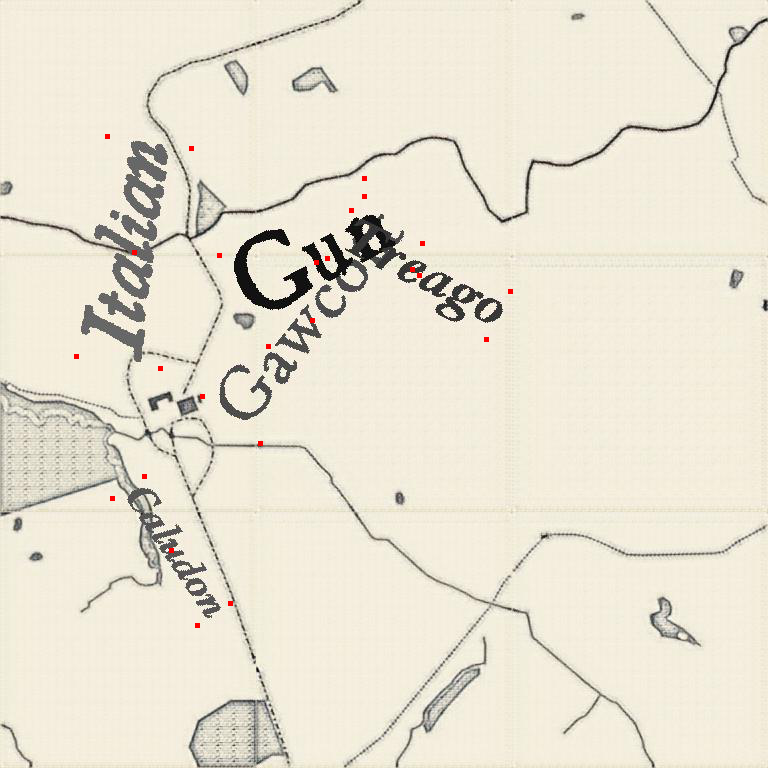

In [11]:
# verify
from IPython.display import display

dot = Image.new('RGB', (5, 5), color='red')
ver_img = Image.open('/data/zekunl/synthMap_application/generate_data/concat_out_text/concat3_32331_21349.jpg')
ver_info = open('/data/zekunl/synthMap_application/generate_data/concat_out_text/concat3_32331_21349.txt')
for line in ver_info:
    text_info = line.strip('\n').split(',')
    for i in range(0,10,2):
        ver_img.paste(dot,(int(text_info[i])-2, int(text_info[i+1])-2))
display(ver_img)

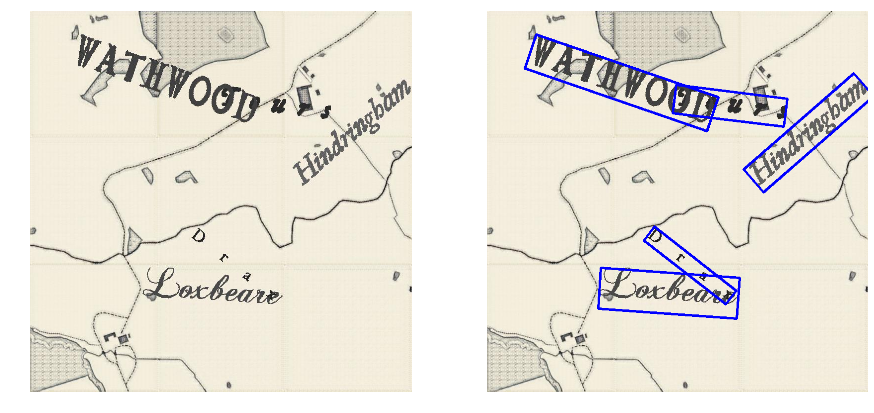

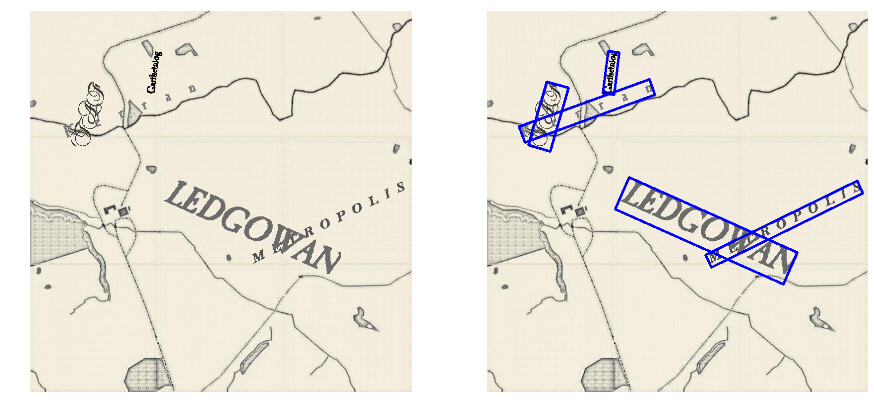

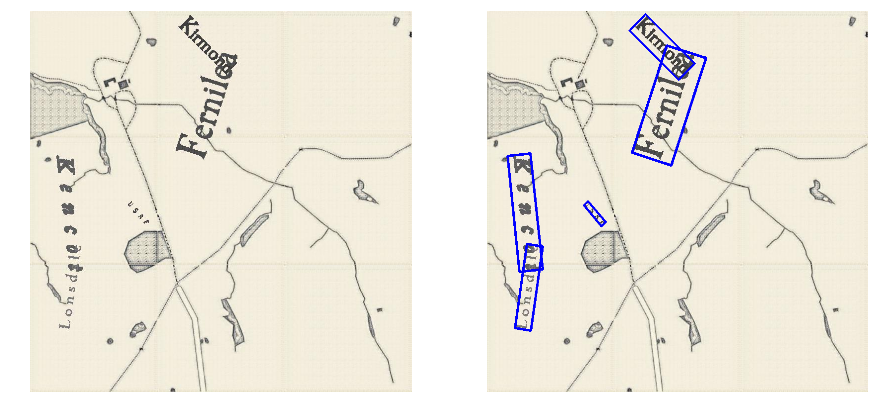

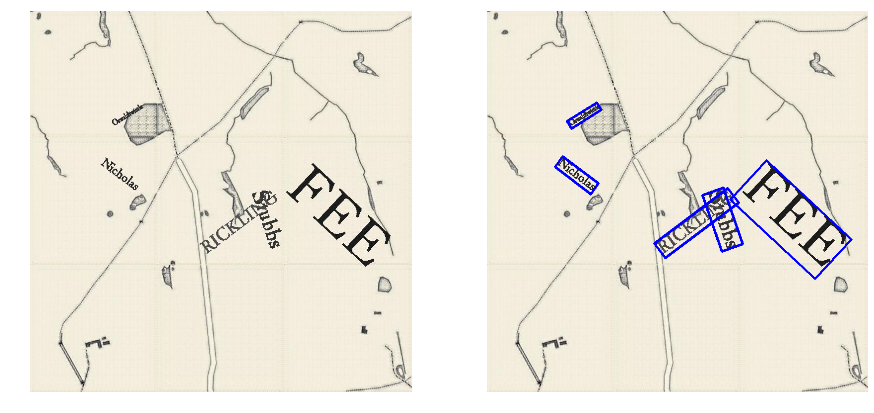

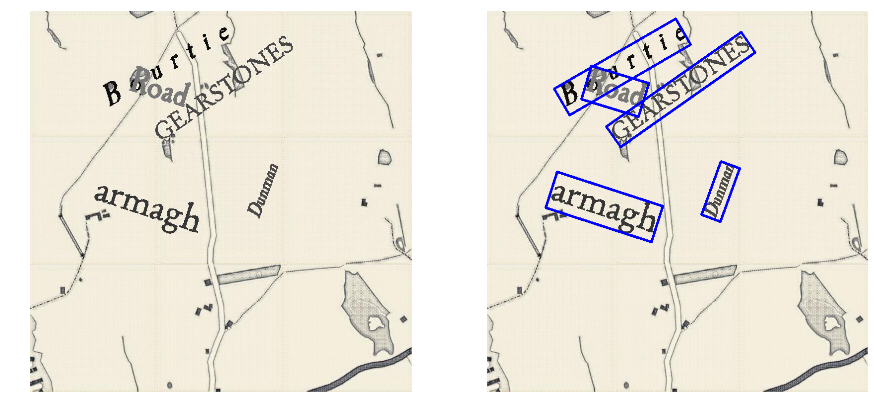

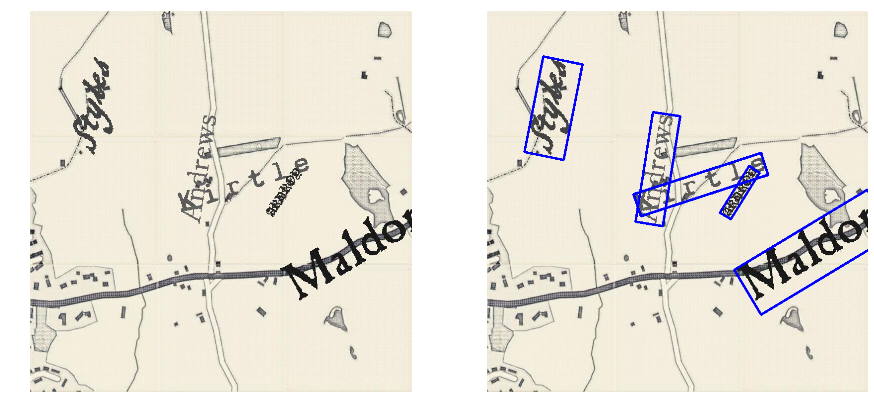

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [27]:
import glob
import cv2
import os
from matplotlib import pyplot as plt


img_paths = glob.glob('/data/zekunl/synthMap_application/generate_data/concat_out_text_space/*.jpg')[0:8]
for img_path in img_paths:
    txt_path = img_path[:-3] + 'txt'
    
    plt.figure(figsize = (15,8))
    plt.subplot(1,2,1)
    img = cv2.imread(img_path)
    plt.imshow(img[:,:,::-1])
    plt.axis('off')
    
    with open(txt_path,'r') as f:
        img2 = img.copy()
        lines = f.readlines()
        for line in lines:
            text_info = line.strip('\n').split(',')
            x1, y1, x2, y2 ,x3, y3, x4, y4, _, _ = [np.int32(a) for a in text_info]
            pts = [[x1,y1],[x2,y2],[x3,y3],[x4,y4]]
            cv2.polylines(img2, np.array([pts]).astype(np.int32), True, (255,0,0), thickness = 3)
            
    plt.subplot(1,2,2)
    plt.imshow(img2[:,:,::-1])
    plt.axis('off')
    plt.show()

In [18]:
points = np.array([[910, 641], [206, 632], [696, 488], [458, 485]])
# points.dtype => 'int64'
cv2.polylines(img, np.int32([points]), 1, (255,255,255))

array([[[202, 218, 225],
        [211, 227, 234],
        [217, 233, 240],
        ...,
        [217, 235, 242],
        [205, 223, 230],
        [187, 205, 212]],

       [[212, 228, 235],
        [219, 235, 242],
        [223, 239, 246],
        ...,
        [223, 241, 248],
        [216, 234, 241],
        [202, 220, 227]],

       [[221, 237, 244],
        [226, 242, 249],
        [228, 244, 251],
        ...,
        [227, 245, 252],
        [226, 244, 251],
        [217, 235, 242]],

       ...,

       [[150, 169, 172],
        [176, 195, 198],
        [204, 223, 226],
        ...,
        [218, 242, 248],
        [214, 236, 242],
        [193, 217, 223]],

       [[142, 163, 165],
        [160, 181, 183],
        [177, 196, 199],
        ...,
        [214, 240, 246],
        [211, 235, 241],
        [191, 217, 223]],

       [[170, 191, 193],
        [163, 184, 186],
        [171, 190, 193],
        ...,
        [200, 226, 232],
        [203, 229, 235],
        [191, 217, 223]]

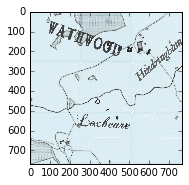

In [19]:
plt.imshow(img)
plt.show()